Importar data y librerias

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

Cargar datos

In [2]:

# Función para cargar los datos desde un archivo CSV
def cargar_datos():
    ruta_archivo = "/content/GEIH2018_filtered_data.csv"
    print(f"Intentando cargar el archivo desde: {ruta_archivo}")

    # Cargar el archivo CSV
    df = pd.read_csv(ruta_archivo)

    print(df.head())  # Confirmación
    return df

# Llamada a la función para cargar los datos
df = cargar_datos()


Intentando cargar el archivo desde: /content/GEIH2018_filtered_data.csv
   directorio  secuencia_p  orden  clase dominio  age  sex  estrato1  p6210  \
0     4514331            1      1      1  BOGOTA   36    1         2      5   
1     4514333            1      1      1  BOGOTA   51    1         2      6   
2     4514334            1      1      1  BOGOTA   45    1         2      3   
3     4514335            1      1      1  BOGOTA   61    1         2      3   
4     4514339            1      1      1  BOGOTA   35    0         2      5   

   p6240  ...  maxEducLevel  totalHoursWorked  formal  informal  cuentaPropia  \
0      1  ...           6.0                45       1         0             0   
1      1  ...           7.0                48       1         0             0   
2      1  ...           4.0                56       1         0             0   
3      1  ...           3.0                40       0         1             0   
4      1  ...           6.0                40   

Correr regresión

In [3]:
# Crear la variable Female que toma 1 si es mujer (sex=0) y 0 si es hombre (sex=1)
df['Female'] = 1 - df['sex']

# Función para realizar la regresión
def realizar_regresion(df):
    # Añadir el logaritmo del salario
    df['log_y_total_m'] = np.log(df['y_total_m'])

    # Definir las variables independientes (Female) y dependientes (logaritmo del salario)
    X = df[['Female']]  # Female es 1 si es mujer, 0 si es hombre
    X = sm.add_constant(X)  # Añadir término constante (para β1)
    y = df['log_y_total_m']  # Logaritmo del salario

    # Realizar la regresión
    modelo = sm.OLS(y, X).fit()

    # resultados de la regresión
    print("Regresión completada. Aquí tienes los resultados:")
    print(modelo.summary())

    return modelo

#  realizar la regresión
modelo = realizar_regresion(df)


Regresión completada. Aquí tienes los resultados:
                            OLS Regression Results                            
Dep. Variable:          log_y_total_m   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     66.42
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           3.99e-16
Time:                        17:06:26   Log-Likelihood:                -14724.
No. Observations:               12826   AIC:                         2.945e+04
Df Residuals:                   12824   BIC:                         2.947e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

FWL

In [4]:
# Función actualizada para manejar valores NaN
def fwl_regresion(df):
    # Variables de control actualizadas
    controles = ['age', 'maxEducLevel', 'formal', 'microEmpresa', 'sizeFirm', 'college']

    # Eliminar filas con valores NaN en las variables relevantes
    df_clean = df[['log_y_total_m', 'Female'] + controles].dropna()

    # 1. Regresión de los controles sobre el logaritmo del salario
    X_controls = df_clean[controles]
    X_controls = sm.add_constant(X_controls)
    y_log_salario = df_clean['log_y_total_m']
    modelo_control_salario = sm.OLS(y_log_salario, X_controls).fit()
    df_clean['residuo_salario'] = modelo_control_salario.resid  # Guardamos los residuos

    # 2. Regresión de los controles sobre la variable Female
    X_female = df_clean['Female']
    modelo_control_female = sm.OLS(X_female, X_controls).fit()
    df_clean['residuo_female'] = modelo_control_female.resid  # Guardamos los residuos

    # 3. Regresión de los residuos de Female sobre los residuos del salario
    modelo_fwl = sm.OLS(df_clean['residuo_salario'], sm.add_constant(df_clean['residuo_female'])).fit()

    # Imprimir los resultados de la regresión FWL
    print("Resultados de la regresión FWL:")
    print(modelo_fwl.summary())

    return modelo_fwl

# Llamada a la función FWL
modelo_fwl = fwl_regresion(df)


Resultados de la regresión FWL:
                            OLS Regression Results                            
Dep. Variable:        residuo_salario   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     295.4
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           1.76e-65
Time:                        17:06:41   Log-Likelihood:                -11922.
No. Observations:               12825   AIC:                         2.385e+04
Df Residuals:                   12823   BIC:                         2.386e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const       

FWL BOOTSTRAPED

In [5]:
from sklearn.utils import resample

# Función para aplicar el bootstrap al modelo FWL sin los controles que generaban error
def fwl_regresion_bootstrap(df, n_iterations=1000):
    coef_bootstrap = []
    std_err_bootstrap = []

    # Variables de control actualizadas
    controles = ['age', 'maxEducLevel', 'formal', 'microEmpresa', 'sizeFirm', 'college']

    # Eliminar filas con valores NaN en las variables relevantes antes del bootstrap
    df_clean = df[['log_y_total_m', 'Female'] + controles].dropna()

    for i in range(n_iterations):
        # Realizar un muestreo con reemplazo sobre el conjunto de datos limpio
        df_bootstrap = resample(df_clean)

        # Repetimos el mismo proceso FWL
        X_controls = df_bootstrap[controles]
        X_controls = sm.add_constant(X_controls)
        y_log_salario = df_bootstrap['log_y_total_m']
        modelo_control_salario = sm.OLS(y_log_salario, X_controls).fit()
        df_bootstrap['residuo_salario'] = modelo_control_salario.resid

        X_female = df_bootstrap['Female']
        modelo_control_female = sm.OLS(X_female, X_controls).fit()
        df_bootstrap['residuo_female'] = modelo_control_female.resid

        modelo_fwl_bootstrap = sm.OLS(df_bootstrap['residuo_salario'], sm.add_constant(df_bootstrap['residuo_female'])).fit()

        # Guardar los coeficientes y errores estándar
        coef_bootstrap.append(modelo_fwl_bootstrap.params[1])  # Coeficiente de Female
        std_err_bootstrap.append(modelo_fwl_bootstrap.bse[1])  # Error estándar de Female

    # Calcular los resultados del bootstrap
    coef_medio = np.mean(coef_bootstrap)
    std_err_medio = np.mean(std_err_bootstrap)

    print(f"Coeficiente promedio (bootstrap): {coef_medio}")
    print(f"Error estándar promedio (bootstrap): {std_err_medio}")

    return coef_medio, std_err_medio

#  realizar el bootstrap
coef_medio, std_err_medio = fwl_regresion_bootstrap(df)
y

#  resultados resumidos del bootstrap
coef_medio, std_err_medio = fwl_regresion_bootstrap(df)

# Mostrar la comparación con los resultados FWL originales
print("\nComparación de los resultados FWL y Bootstrap:")
print(f"FWL - Coeficiente Female: {modelo_fwl.params['residuo_female']}")
print(f"FWL - Error estándar: {modelo_fwl.bse['residuo_female']}")
print(f"Bootstrap - Coeficiente promedio Female: {coef_medio}")
print(f"Bootstrap - Error estándar promedio: {std_err_medio}")


<ipython-input-5-2c33dd64b1d6>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_bootstrap.append(modelo_fwl_bootstrap.params[1])  # Coeficiente de Female
<ipython-input-5-2c33dd64b1d6>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err_bootstrap.append(modelo_fwl_bootstrap.bse[1])  # Error estándar de Female
<ipython-input-5-2c33dd64b1d6>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_bootstrap.append(modelo_fwl

Coeficiente promedio (bootstrap): -0.18856225362736342
Error estándar promedio (bootstrap): 0.010948170412892474


<ipython-input-5-2c33dd64b1d6>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err_bootstrap.append(modelo_fwl_bootstrap.bse[1])  # Error estándar de Female
<ipython-input-5-2c33dd64b1d6>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_bootstrap.append(modelo_fwl_bootstrap.params[1])  # Coeficiente de Female
<ipython-input-5-2c33dd64b1d6>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err_bootstrap.append(modelo_

Coeficiente promedio (bootstrap): -0.1880054098818156
Error estándar promedio (bootstrap): 0.010944643436456503

Comparación de los resultados FWL y Bootstrap:
FWL - Coeficiente Female: -0.1880950298295791
FWL - Error estándar: 0.010943311393016486
Bootstrap - Coeficiente promedio Female: -0.1880054098818156
Bootstrap - Error estándar promedio: 0.010944643436456503


<ipython-input-5-2c33dd64b1d6>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_bootstrap.append(modelo_fwl_bootstrap.params[1])  # Coeficiente de Female
<ipython-input-5-2c33dd64b1d6>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err_bootstrap.append(modelo_fwl_bootstrap.bse[1])  # Error estándar de Female
<ipython-input-5-2c33dd64b1d6>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef_bootstrap.append(modelo_fwl

PERFIL EDAD-SALARIO


In [8]:
# Función para realizar la regresión age-wage, eliminando NaN
def realizar_regresion_age_wage(df, controles=None):
    # Variables independientes clave

    if 'age_squared' not in df.columns:
        df['age_squared'] = df['age']**2
    if 'Female_Age' not in df.columns:
        df['Female_Age'] = df['Female'] * df['age']
    if 'Female_Age_squared' not in df.columns:
        df['Female_Age_squared'] = df['Female'] * df['age_squared']

    X = df[['age', 'age_squared', 'Female', 'Female_Age', 'Female_Age_squared']]

    if controles:
        # Añadir controles si se especifican
        X = pd.concat([X, df[controles]], axis=1)

    # Eliminar filas con NaN antes de añadir constante
    df_clean = df[['log_y_total_m'] + X.columns.tolist()].dropna()

    # Variable dependiente
    y = df_clean['log_y_total_m']

    # Variables explicativas sin NaN
    X_clean = df_clean[X.columns]

    # Añadir constante
    X_clean = sm.add_constant(X_clean)

    # Realizar la regresión
    modelo = sm.OLS(y, X_clean).fit()
    return modelo

# Correr los modelos condicional e incondicional
controles = ['maxEducLevel', 'formal', 'microEmpresa', 'sizeFirm', 'college']
modelo_incondicional = realizar_regresion_age_wage(df)
modelo_condicional = realizar_regresion_age_wage(df, controles=controles)

# Imprimir resultados
print("Modelo Incondicional:")
print(modelo_incondicional.summary())

print("\nModelo Condicional:")
print(modelo_condicional.summary())

Modelo Incondicional:
                            OLS Regression Results                            
Dep. Variable:          log_y_total_m   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     139.8
Date:                Sun, 15 Sep 2024   Prob (F-statistic):          7.39e-145
Time:                        17:09:54   Log-Likelihood:                -14417.
No. Observations:               12826   AIC:                         2.885e+04
Df Residuals:                   12820   BIC:                         2.889e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const         

GRAFICO



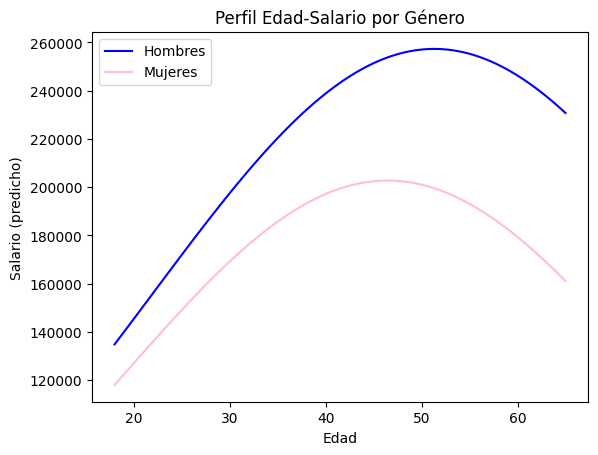

In [9]:
# Función para predecir el salario basado en la edad, por género
def predecir_salario_edad(modelo, min_age, max_age, female=0):
    edades = np.linspace(min_age, max_age, 100)
    predicciones = (
        modelo.params['const'] +
        modelo.params['age'] * edades +
        modelo.params['age_squared'] * (edades ** 2) +
        female * (
            modelo.params['Female'] +
            modelo.params['Female_Age'] * edades +
            modelo.params['Female_Age_squared'] * (edades ** 2)
        )
    )
    return edades, predicciones

# Graficar el perfil edad-salario para hombres y mujeres
edades_hombres, predicciones_hombres = predecir_salario_edad(modelo_condicional, min_age=18, max_age=65, female=0)
edades_mujeres, predicciones_mujeres = predecir_salario_edad(modelo_condicional, min_age=18, max_age=65, female=1)

plt.plot(edades_hombres, np.exp(predicciones_hombres), label="Hombres", color='blue')
plt.plot(edades_mujeres, np.exp(predicciones_mujeres), label="Mujeres", color='pink')
plt.xlabel("Edad")
plt.ylabel("Salario (predicho)")
plt.title("Perfil Edad-Salario por Género")
plt.legend()
plt.show()


PEAK AGE

In [12]:
from sklearn.utils import resample
import numpy as np

# Función para realizar el bootstrap de la peak age
def bootstrap_peak_age(df, n_iterations=1000):
    peak_ages_hombres = []
    peak_ages_mujeres = []

    for i in range(n_iterations):
        # Resamplear los datos con reemplazo
        df_bootstrap = resample(df)

        # Reestimamos el modelo en la muestra resampleada
        modelo_bootstrap = realizar_regresion_age_wage(df_bootstrap, controles=['maxEducLevel', 'formal', 'microEmpresa', 'sizeFirm', 'college'])

        # Calcular la peak age para hombres (female=0)
        b1_hombres = modelo_bootstrap.params['age']
        b2_hombres = modelo_bootstrap.params['age_squared']
        peak_age_hombres = -b1_hombres / (2 * b2_hombres)
        peak_ages_hombres.append(peak_age_hombres)

        # Calcular la peak age para mujeres (female=1)
        b1_mujeres = modelo_bootstrap.params['age'] + modelo_bootstrap.params['Female_Age']
        b2_mujeres = modelo_bootstrap.params['age_squared'] + modelo_bootstrap.params['Female_Age_squared']
        peak_age_mujeres = -b1_mujeres / (2 * b2_mujeres)
        peak_ages_mujeres.append(peak_age_mujeres)

    return np.array(peak_ages_hombres), np.array(peak_ages_mujeres)

# Aplicar el bootstrap para calcular las edades de pico
peak_ages_hombres, peak_ages_mujeres = bootstrap_peak_age(df)

# Calcular los intervalos de confianza al 95%
ci_hombres = np.percentile(peak_ages_hombres, [2.5, 97.5])
ci_mujeres = np.percentile(peak_ages_mujeres, [2.5, 97.5])

#  resultados
print(f"Edad de pico (Hombres): {np.mean(peak_ages_hombres)} con IC al 95%: {ci_hombres}")
print(f"Edad de pico (Mujeres): {np.mean(peak_ages_mujeres)} con IC al 95%: {ci_mujeres}")


Edad de pico (Hombres): 51.38490298165187 con IC al 95%: [49.54679117 53.73602708]
Edad de pico (Mujeres): 46.52158829574575 con IC al 95%: [44.90183161 48.41707266]
